In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/C247-NNDL/

/content/drive/MyDrive/C247-NNDL


# IMPORTS

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from matplotlib.collections import LineCollection

from sklearn.metrics import accuracy_score

%pylab inline

import torch
import torch.nn as nn
import torch.autograd as autograd
import torchvision
import torchvision.models as models
import torchvision.transforms as T
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.modules.activation import LeakyReLU

from torchsummary import summary

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir="Results/runs")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Populating the interactive namespace from numpy and matplotlib


# DATA PREPROCESSING AND RESHAPING

In [ ]:
## Loading the numpy arrays corresponding to the EEG dataset

X_test = np.load("./Dataset/X_test.npy")
y_test = np.load("./Dataset/y_test.npy")
person_train_valid = np.load("./Dataset/person_train_valid.npy")
X_train_valid = np.load("./Dataset/X_train_valid.npy")
y_train_valid = np.load("./Dataset/y_train_valid.npy")
person_test = np.load("./Dataset/person_test.npy")

## Printing the shapes of the numpy arrays

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [ ]:
## Adjusting the labels to {0,1,2,3}

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

# DATA PREPROCESSING AND AUGMENTATION

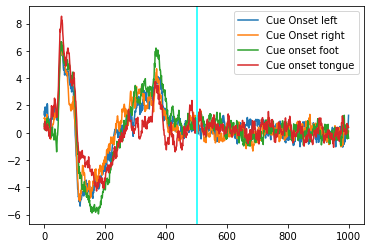

In [ ]:

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [ ]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y

In [ ]:
## Preprocessing the dataset

X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)

print(X_train_valid_prep.shape)
print(y_train_valid_prep.shape)
print(X_test_prep.shape)
print(y_test_prep.shape)

Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
(8460, 22, 250)
(8460,)
(1772, 22, 250)
(1772,)


# CREATING TRAIN AND VALIDATION

WITH PREPROCESSING AND AUGMENTATION

In [ ]:
## Creating the training and validation sets

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(8460, 1500, replace=False)
ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

X_test = X_test_prep
y_test = y_test_prep

print('Shape of test set:',X_test.shape)
print('Shape of test labels:',y_test.shape)

Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Shape of test set: (1772, 22, 250)
Shape of test labels: (1772,)


# VISUALIZING A SAMPLE EEG DATA

In [ ]:
# Taken from: https://notebook.community/joannekoong/neuroscience_tutorials/basic/1.%20Load%20EEG%20data%20and%20plot%20ERP

def plot_eeg(EEG, vspace=100, color='k'):   
    bases = vspace * np.arange(22)    
    EEG = EEG.T + bases
    
    # Calculate a timeline in seconds, assuming that the sample rate of the EEG recorder was 2048 Hz.
    samplerate = 2048
    time = arange(EEG.shape[0]) / samplerate
    
    # Plot EEG versus time
    plot(time, EEG, color=color)
    grid()
    xlabel('Time (s)')
    ylabel('Channels')
    gca().yaxis.set_ticks(bases)
    title('EEG data for a single sample')

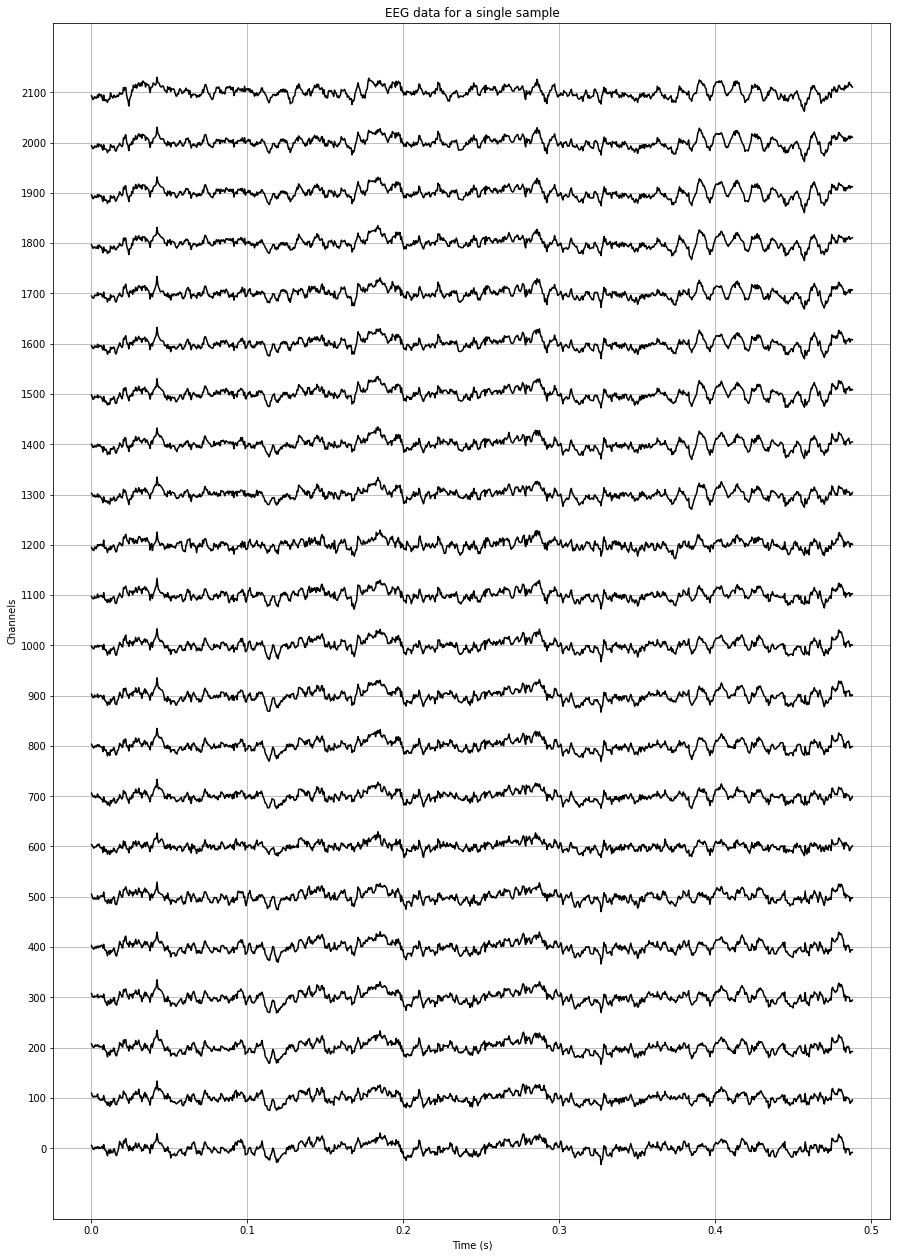

In [ ]:
figure(figsize=(15,22))
plot_eeg(X_train_valid[0])

# DATALOADER

In [ ]:
# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(X_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Shape of training set after dimension reshaping: (6960, 250, 22)
Shape of validation set after dimension reshaping: (1500, 250, 22)
Shape of test set after dimension reshaping: (1772, 250, 22)


In [ ]:
# Normalize each channel to have mean 0 and std 1
def standardize(x):
    mean = np.mean(x, axis=1)
    var = np.var(x, axis=1)

    return (x - mean[:, None]) / np.sqrt(var)[:, None]

x_train = standardize(x_train)
x_valid = standardize(x_valid)
x_test = standardize(x_test)

In [ ]:
class LoadData(Dataset):
    def __init__(self, data, labels):
        self.data = torch.Tensor(data)
        self.labels = labels

    def __len__(self) -> int:
        return len(self.data)
    
    def __getitem__(self, index: int):
        input_data = self.data[index].permute(1,0)
        input_label = self.labels[index]
        return (input_data, input_label)

In [ ]:
train_dataset = LoadData(data=x_train, labels=y_train,)
val_dataset = LoadData(data=x_valid, labels=y_valid,)
train_dl = DataLoader(train_dataset, batch_size=16, num_workers=1, pin_memory=True, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=16, num_workers=1, pin_memory=True)

data = next(iter(train_dl))
input_data, input_labels = data
print(input_data.size())

torch.Size([16, 22, 250])


tensor(1, dtype=torch.int32)


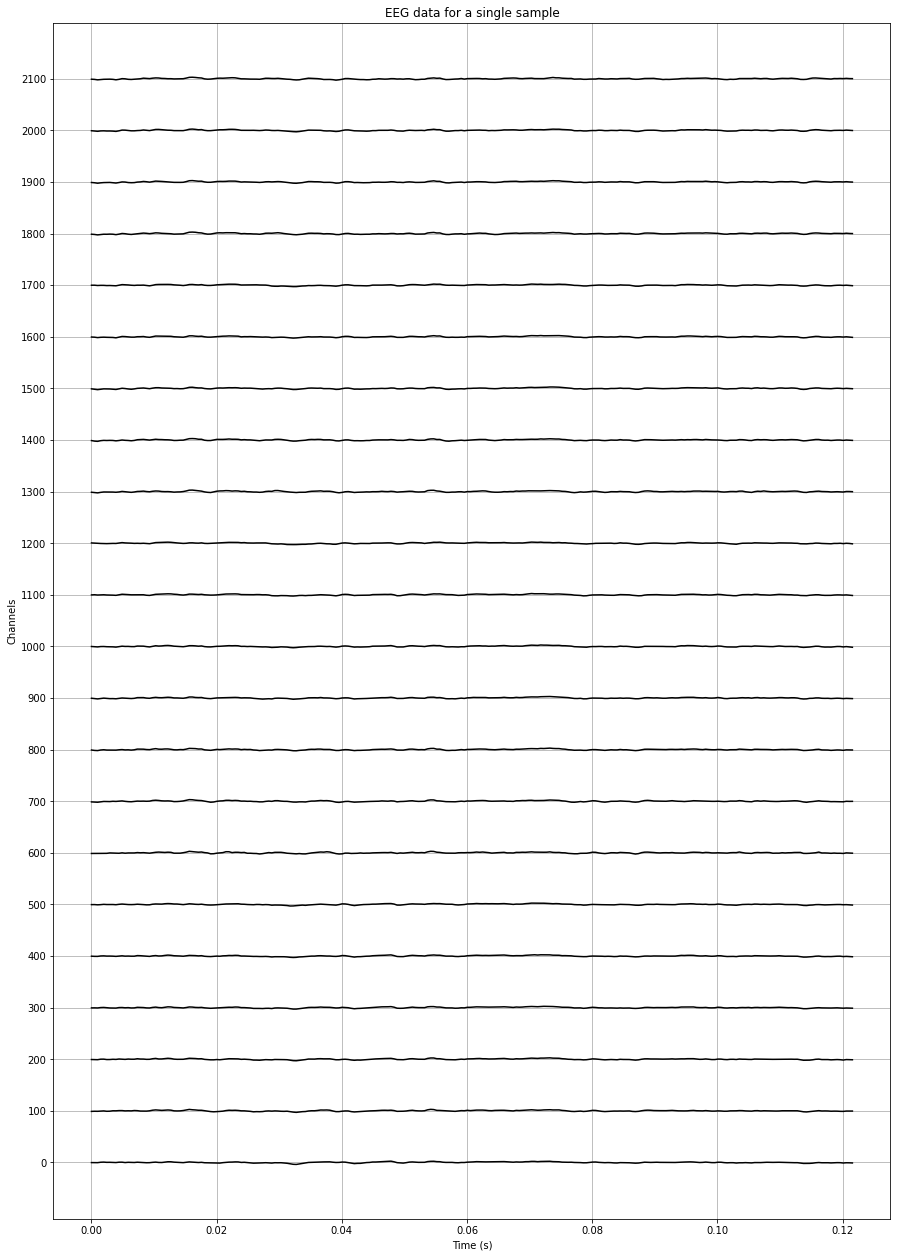

In [ ]:
print(data[1][12])
figure(figsize=(15,22))
plot_eeg(data[0][12])

# WGAN

1D

In [ ]:
class WGANGen(nn.Module):
    def __init__(self, noise_dim=100):
        super(WGANGen, self).__init__()
        # self.scaler = nn.Linear(64 * 50, 64 * 352 * 14)
        self.label_emb = nn.Embedding(4, 4)

        self.fc1 = nn.Linear(in_features=noise_dim + 4, out_features=352 * 14)
        self.bnorm1 = nn.BatchNorm1d(352 * 14)
        self.relu1 = nn.LeakyReLU(0.3)
        self.dropout1 = nn.Dropout(p=0.5)

        self.deconv1 = nn.ConvTranspose1d(352, 176, 5, stride=2, padding=1, output_padding=1, bias=False)
        self.bnorm2 = nn.BatchNorm1d(176)
        self.relu2 = nn.LeakyReLU(0.3)
        self.dropout2 = nn.Dropout(p=0.5)

        self.deconv2 = nn.ConvTranspose1d(176, 88, 5, stride=2, padding=1, output_padding=1, bias=False)
        self.bnorm3 = nn.BatchNorm1d(88)
        self.relu3 = nn.LeakyReLU(0.3)
        self.dropout3 = nn.Dropout(p=0.5)

        self.deconv3 = nn.ConvTranspose1d(88, 44, 5, stride=2, padding=2, output_padding=1, bias=False)
        self.bnorm4 = nn.BatchNorm1d(44)
        self.relu4 = nn.LeakyReLU(0.3)
        self.dropout4 = nn.Dropout(p=0.5)

        self.deconv4 = nn.ConvTranspose1d(44, 22, 5, stride=2, padding=1, output_padding=1, bias=False)
        self.tanh = nn.Tanh()

    def forward(self, x, labels):

        h = torch.cat((self.label_emb(labels), x), -1)
        # print(h.shape)

        h = self.fc1(h)
        h = self.bnorm1(h)
        h = self.relu1(h)
        h = torch.reshape(h, (64, 352, 14))
        h = self.dropout1(h)

        # print(h.shape)

        h = self.deconv1(h)
        h = self.bnorm2(h)
        h = self.relu2(h)
        h = self.dropout2(h)
        # print(h.shape)

        h = self.deconv2(h)
        h = self.bnorm3(h)
        h = self.relu3(h)
        h = self.dropout3(h)
        # print(h.shape)

        h = self.deconv3(h)
        h = self.bnorm4(h)
        h = self.relu4(h)
        h = self.dropout4(h)
        # print(h.shape)
        
        h = self.deconv4(h)
        h = self.tanh(h)

        # print(h.shape)

        return h

class WGANDis(nn.Module):
    def __init__(self):
        super(WGANDis, self).__init__()
        self.scaler = nn.Linear(4, 250 * 22)
        self.label_emb = nn.Embedding(4, 4)

        self.conv1 = nn.Conv1d(44, 64, 2, stride=2, padding=0)
        self.bnorm1 = nn.BatchNorm1d(64)
        self.relu1 = LeakyReLU(0.3)

        self.conv2 = nn.Conv1d(64, 128, 2, stride=2, padding=0)
        self.bnorm2 = nn.BatchNorm1d(128)
        self.relu2 = LeakyReLU(0.3)

        self.conv3 = nn.Conv1d(128, 256, 2, stride=2, padding=0)
        self.bnorm3 = nn.BatchNorm1d(256)
        self.relu3 = LeakyReLU(0.3)

        self.conv4 = nn.Conv1d(256, 512, 2, stride=2, padding=0)
        self.bnorm4 = nn.BatchNorm1d(512)
        self.relu4 = LeakyReLU(0.3)

        self.dropout1 = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(7680, 1)
    
    def forward(self, x, labels):
        labels = labels.long()
        li = self.label_emb(labels)
        li = self.scaler(li)
        li = torch.reshape(li, (64, 22, 250))
        # print(li.shape)

        h = torch.cat((x, li), 1)

        h = self.conv1(h)
        h = self.bnorm1(h)
        h = self.relu1(h)

        h = self.conv2(h)
        h = self.bnorm2(h)
        h = self.relu2(h)

        h = self.conv3(h)
        h = self.bnorm3(h)
        h = self.relu3(h)

        h = self.conv4(h)
        h = self.bnorm4(h)
        h = self.relu4(h)

        h = torch.flatten(h, 1)

        h = self.dropout1(h)
        h = self.fc1(h)

        return h

GRADIENT PENALTY

In [ ]:
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor
lambda_gp = 10
n_critic = 5

def compute_gradient_penalty(D, real_samples, fake_samples, labels):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1)))
    labels = LongTensor(labels)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates, labels)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# TRAINING

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Conv1d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)    
    elif isinstance(m, nn.ConvTranspose1d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm1d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

WGAN

In [ ]:
class Trainer:
    def __init__(self, epochs, batch_size, learning_rate, num_workers, train_data, valid_data, train_labels, valid_labels, validate_after):
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_workers = num_workers
        self.train_data = train_data
        self.valid_data = valid_data
        self.train_labels = train_labels
        self.valid_labels = valid_labels
        self.real_label = 1
        self.fake_label = 0
        self.validate_after = validate_after

    def train(self):
        train_dataset = LoadData(data=self.train_data, labels=self.train_labels)
        train_dataloader = DataLoader(train_dataset, batch_size=self.batch_size, num_workers=self.num_workers,pin_memory=True)
        # Model
        model_G = WGANGen().to(device)
        model_D = WGANDis().to(device)
        model_G.apply(weights_init)
        model_D.apply(weights_init)

        optimizer_G = torch.optim.Adam(model_G.parameters(),
                             lr=self.learning_rate, betas=(0, 0.9),
                             eps=1e-8, weight_decay=0)
        optimizer_D = torch.optim.Adam(model_D.parameters(),
                             lr=self.learning_rate, betas=(0, 0.9),
                             eps=1e-8, weight_decay=0)
        
        # Loss function to use
        criterion = nn.BCELoss()
        # You may also use a combination of more than one loss function 
        # or create your own.

        model_G.train()
        model_D.train()


        # train loop
        for epoch in range(self.epochs):
            print("Starting Training Epoch " + str(epoch + 1))
            # loop_start = time.time()
            # avg_loss = 0.0
            # main_start = time.time()
            for i, data in enumerate(tqdm(train_dataloader)):                                                    #(train_dataloader, 0)?
                if i == len(train_dataloader) - 1:
                    continue
                    
                for parm in model_D.parameters():
                    parm.data.clamp_(-0.01, 0.01)

                inputs, targets = data
                inputs = inputs.to(device, dtype=torch.float64)
                targets = targets.to(device, dtype=torch.long)
                # print(targets.shape)

                real = Variable(inputs.type(Tensor))

                model_D.zero_grad()
                label = torch.full(targets.shape, self.real_label, dtype=torch.float, device=device)

                n_select = int(0.05 * label.shape[0])
                flip_ix = choice([i for i in range(label.shape[0])], size=n_select)                   # noisy labels
                label[flip_ix] = 1 - label[flip_ix]

                label -= 0.3 + (torch.rand(label.shape, device=device) * 0.5)                         # label smoothing
                output_real = model_D(inputs.float(), targets).view(-1)
                # print(output.shape)
                errD_real = -torch.mean(output_real)
                # errD_real.backward()
                # train with fake

                # Get Output of Generator, fake images
                noise = Variable(Tensor(np.random.normal(0, 1, (inputs.shape[0], 100))))
                fake = model_G(noise, targets)
                
                # print(fake.shape)
                label.fill_(self.fake_label)
                flip_ix = choice([i for i in range(label.shape[0])], size=n_select)                   # noisy labels
                label[flip_ix] = 1 - label[flip_ix]
                label = label + torch.rand(label.shape, device=device) * 0.3                         # label smoothing
                # Classify all fake batch with D
                output_fake = model_D(fake.detach(), targets).view(-1)
                # Calculate D's loss on the all-fake batch
                errD_fake = torch.mean(output_fake)
                # # Calculate the gradients for this batch, accumulated (summed) with previous gradients
                # errD_fake.backward()

                gradient_penalty = compute_gradient_penalty(model_D, real.data, fake.data, targets.data)

                # Compute error of D as sum over the fake and the real batches
                errD = errD_real + errD_fake + lambda_gp * gradient_penalty
                errD.backward()
                # Update D
                optimizer_D.step()

                ########################
                # update G network
                ########################
                model_G.zero_grad()

                if i % n_critic == 0:

                    label.fill_(self.real_label)                                                          # fake labels are real for generator cost
                    # Since we just updated D, perform another forward pass of all-fake batch through D
                    output = model_D(fake, targets)
                    # Calculate G's loss based on this output
                    # print(output.shape)
                    # print(label.shape)
                    output = torch.reshape(output, label.shape)
                    errG = -torch.mean(output)
                    # Calculate gradients for G
                    errG.backward()
                    # Update G
                    optimizer_G.step()                                                                       # Update the weights

                    # avg_loss += loss.item()

            print(f'Training: Epoch {epoch + 1} \t\t Discriminator Loss: {\
                errD / len(train_dataloader)}  \t\t Generator Loss: {\
                errG / len(train_dataloader)}')
            
            if (epoch + 1) % self.validate_after == 0:
                errD_val, errG_val, val_len = self.validate(model_D, model_G, criterion)
                print(f'Validation: Epoch {epoch + 1} \t\t Discriminator Loss: {\
                        errD_val / val_len}  \t\t Generator Loss: {\
                        errG_val / val_len}')
                # model.eval()
                # for i, data in enumerate(tqdm(val_dataloader))
                
            torch.save(model_G.state_dict(), './Results/Model_GAN/Generator_WGAN/saved_model_' + str(epoch + 1) + '.pth')
            torch.save(model_D.state_dict(), './Results/Model_GAN/Discriminator/saved_model_' + str(epoch + 1) + '.pth')


    def validate(self, model_D, model_G, criterion):
        # Validation loop begin
        # ------
        # Validation loop end
        # ------
        # Determine your evaluation metrics on the validation dataset.
        model_G.eval()
        model_D.eval()
        with torch.no_grad():
            val_loss = 0.0
            val_dataset = LoadData(data=self.valid_data, labels=self.valid_labels)
            val_dataloader = DataLoader(val_dataset, batch_size=self.batch_size, num_workers=self.num_workers,pin_memory=True)
            for i, data in enumerate(val_dataloader):
                if i == len(val_dataloader) - 1:
                    continue
                    
                for parm in model_D.parameters():
                    parm.data.clamp_(-0.01, 0.01)

                inputs, targets = data
                inputs = inputs.to(device, dtype=torch.float64)
                targets = targets.to(device, dtype=torch.long)

                label = torch.full(targets.shape, self.real_label, dtype=torch.float, device=device)
                label -= 0.3 + (torch.rand(label.shape, device=device) * 0.5)

                output = model_D(inputs.float(), targets).view(-1)
                # print(output.shape)
                errD_real = -torch.mean(output)
                # errD_real.backward()

                # train with fake
                # noise = torch.randn(self.batch_size, 100, 1, 1, device=device)
                # Generate fake image batch with G
                noise = torch.randn(inputs.shape[0], 100, device=device)
                fake = model_G(noise, targets)

                label.fill_(self.fake_label)
                label = label + torch.rand(label.shape, device=device) * 0.3

                # Classify all fake batch with D
                output = model_D(fake.detach(), targets).view(-1)
                # Calculate D's loss on the all-fake batch
                errD_fake = torch.mean(output)
                # Calculate the gradients for this batch, accumulated (summed) with previous gradients
                # errD_fake.backward()
                # Compute error of D as sum over the fake and the real batches
                errD = errD_real + errD_fake
                # Update D
                # optimizer_D.step()

                ########################
                # update G network
                ########################
                # model_G.zero_grad()
                label.fill_(self.real_label)  # fake labels are real for generator cost
                label = label - 0.3 + (torch.rand(label.shape, device=device) * 0.5)
                # Since we just updated D, perform another forward pass of all-fake batch through D
                output = model_D(fake, targets)
                # Calculate G's loss based on this output
                output=torch.reshape(output, label.shape)
                errG = -torch.mean(output)
                # Calculate gradients for G
                # errG.backward()
                # Update G
                # optimizer_G.step()

        # model.train()
        return errD, errG, len(val_dataloader)

In [ ]:
trainer = Trainer(epochs = 1000, batch_size = 64, learning_rate = 1e-4, num_workers = 2, train_data=x_train, valid_data=x_valid, train_labels=y_train, valid_labels=y_valid, validate_after=1)

In [ ]:
best_model = trainer.train()
writer.flush()

# TESTING

LOADING MODEL FROM CHECKPOINT

In [ ]:
model_no = 1000

In [ ]:
model_test = WGANGen()
model_test.load_state_dict(torch.load('./Results/Model_GAN/Generator_WGAN/saved_model_' + str(model_no) + '.pth', map_location=torch.device('cpu')))
model_test.eval()

WGANGen(
  (label_emb): Embedding(4, 4)
  (fc1): Linear(in_features=104, out_features=4928, bias=True)
  (bnorm1): BatchNorm1d(4928, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.3)
  (dropout1): Dropout(p=0.5, inplace=False)
  (deconv1): ConvTranspose1d(352, 176, kernel_size=(5,), stride=(2,), padding=(1,), output_padding=(1,), bias=False)
  (bnorm2): BatchNorm1d(176, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.3)
  (dropout2): Dropout(p=0.5, inplace=False)
  (deconv2): ConvTranspose1d(176, 88, kernel_size=(5,), stride=(2,), padding=(1,), output_padding=(1,), bias=False)
  (bnorm3): BatchNorm1d(88, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.3)
  (dropout3): Dropout(p=0.5, inplace=False)
  (deconv3): ConvTranspose1d(88, 44, kernel_size=(5,), stride=(2,), padding=(2,), output_padding=(1,), bias=False)
  (bnorm4): Bat

In [ ]:
model_test = WGANDis()
model_test.eval()

WGANDis(
  (scaler): Linear(in_features=4, out_features=5500, bias=True)
  (label_emb): Embedding(4, 4)
  (conv1): Conv1d(44, 64, kernel_size=(2,), stride=(2,))
  (bnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.3)
  (conv2): Conv1d(64, 128, kernel_size=(2,), stride=(2,))
  (bnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.3)
  (conv3): Conv1d(128, 256, kernel_size=(2,), stride=(2,))
  (bnorm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.3)
  (conv4): Conv1d(256, 512, kernel_size=(2,), stride=(2,))
  (bnorm4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): LeakyReLU(negative_slope=0.3)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=7680, out_features=1, bias=True)
)

In [ ]:
test_dataset = LoadData(data=x_test, labels=y_test)
test_dataloader = DataLoader(test_dataset, batch_size=64, num_workers=2,pin_memory=True)

In [ ]:
test_data, labels = next(iter(test_dataloader))
noise = torch.randn(test_data.shape[0], 100)
outputs = model_test(noise, labels)

In [ ]:
print(outputs.shape)
print(outputs[0].shape)
output = torch.reshape(outputs[1], (22, 250))
print(output.shape)

torch.Size([64, 22, 250])
torch.Size([22, 250])
torch.Size([22, 250])


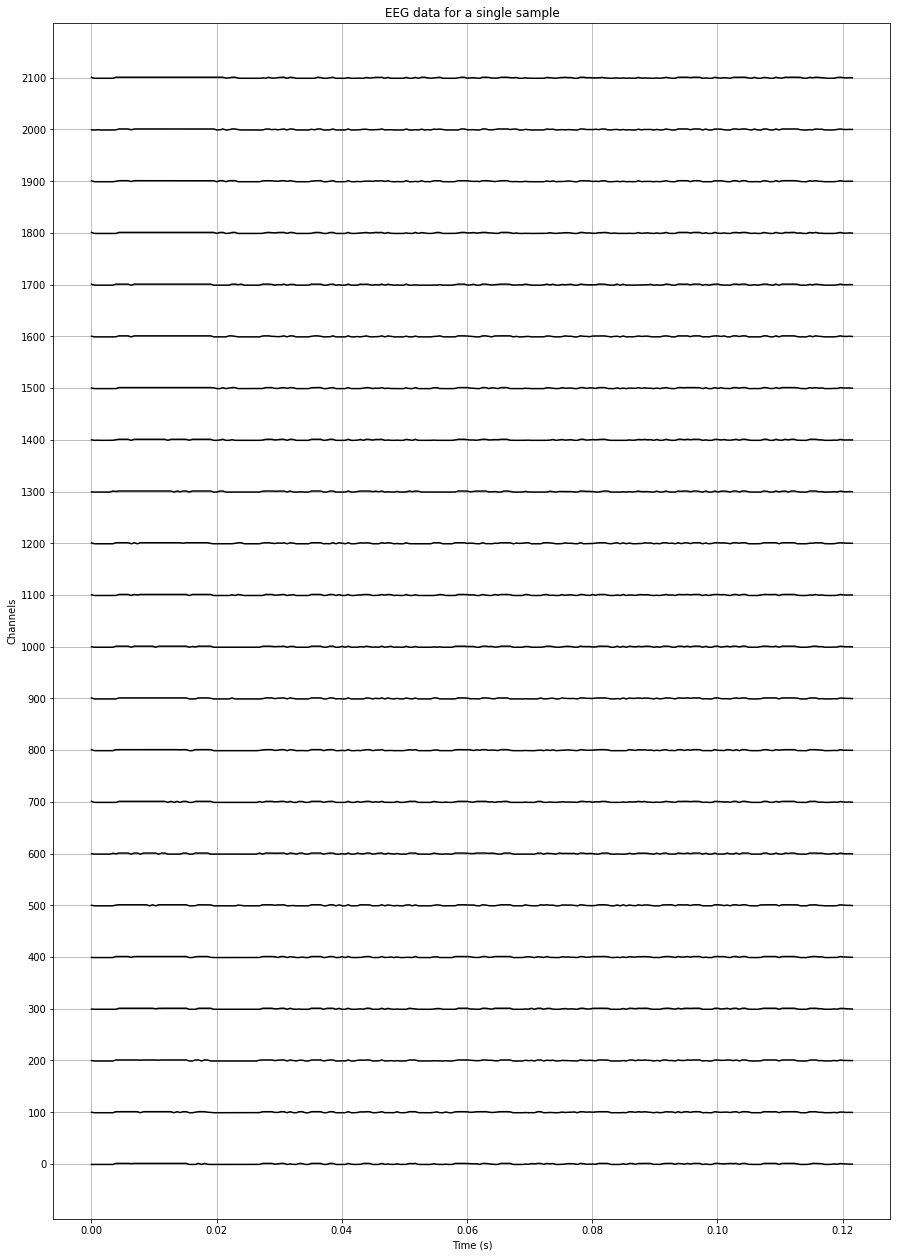

In [ ]:
figure(figsize=(15,22))
plot_eeg(output.detach().numpy())

In [ ]:
print(labels)

tensor([1, 0, 2, 3, 3, 2, 2, 3, 3, 0, 2, 3, 2, 0, 1, 1, 3, 3, 2, 0, 2, 1, 0, 1,
        3, 2, 0, 1, 1, 3, 2, 2, 1, 1, 2, 0, 0, 0, 0, 3, 1, 2, 0, 1, 3, 2, 0, 3,
        2, 1, 1, 2, 0, 3, 3, 1, 1, 3, 3, 2, 1, 1, 3, 1], dtype=torch.int32)
